In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
TRAINING_IMG = "/content/drive/MyDrive/data/train"
TRAINING_MASK = "/content/drive/MyDrive/data/train_masks"
TEST_IMG = "/content/drive/MyDrive/data/test"
TEST_MASK = "/content/drive/MyDrive/data/test_masks"
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 16
NUM_WORKERS = 2
NUM_EPOCH = 20

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, images_path, masks_path, transform_img=None, transform_mask=None):
    self.img_dir = images_path
    self.mask_dir = masks_path
    self.transform_img = transform_img
    self.transform_mask = transform_mask
    self.image_filenames = os.listdir(images_path)

  def __getitem__(self, idx):
    img_name = self.image_filenames[idx]
    img_file_path = os.path.join(self.img_dir, img_name)
    mask_file_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))

    image = Image.open(img_file_path).convert('RGB')
    mask = Image.open(mask_file_path).convert('L')

    # tr = transforms.ToTensor()
    # image = tr(image)
    # mask = tr(mask)
    # image = np.array(image)
    # mask = np.array(mask)

    if self.transform_img:
      # image = self.transform_img(image)
      # mask = self.transform_img(mask)
      image = np.array(image)
      mask = np.array(mask)
      augmented = self.transform_img(image=image, mask=mask)
      image = augmented['image']
      mask = augmented['mask']
      image = transforms.ToTensor()(image)
      mask = transforms.ToTensor()(mask)
      # print("Number of augmentations:", len(augmented))
    # if self.transform_mask:
    #   mask = self.transform_mask(mask)
    # image = transforms.ToTensor()(image)
    # mask = transforms.ToTensor()(mask)

    # tr = transforms.ToTensor()
    # mask = tr(mask)
    # mask = mask / 255.0
    mask = torch.squeeze(mask, dim=0)
    return image, mask

  def __len__(self):
    return len(self.image_filenames)

In [ ]:
class CustomDataLoader:
  def __init__(self, train_dir=TRAINING_IMG, train_mask_dir=TRAINING_MASK, test_dir=TEST_IMG, test_mask_dir=TEST_MASK, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    self.train_dir = train_dir
    self.train_mask_dir = train_mask_dir
    self.test_dir = test_dir
    self.test_mask_dir = test_mask_dir
    self.batch_size = batch_size
    self.num_workers = num_workers
    # self.transform = None

  def setup(self):
    # transform_image = transforms.Compose([
    #   transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    #   transforms.RandomHorizontalFlip(),
    #   transforms.RandomVerticalFlip(),
    #   transforms.RandomRotation(30),
    #   transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #   transforms.ToTensor(),
    #   # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    # ])
    transform_image = A.Compose([
      A.Resize(IMG_WIDTH, IMG_HEIGHT),
      A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
      A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
      A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
      # A.ToTensor(),
      # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    transform_test = A.Compose([
      A.Resize(IMG_WIDTH, IMG_HEIGHT)
      # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    # self.train_dataset = CustomDataset(self.train_dir, self.train_mask_dir, transform_img=transform_image, transform_mask=transform_mask)
    # self.test_dataset = CustomDataset(self.test_dir, self.test_mask_dir, transform_img=transform_image, transform_mask=transform_mask)
    self.train_dataset = CustomDataset(self.train_dir, self.train_mask_dir, transform_img=transform_image)
    self.test_dataset = CustomDataset(self.test_dir, self.test_mask_dir, transform_img=transform_test)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [ ]:
data_loader = CustomDataLoader()
data_loader.setup()

In [ ]:
sample_images, sample_masks = next(iter(data_loader.train_dataloader()))

In [ ]:
sample_images, sample_masks = next(iter(data_loader.test_dataloader()))

In [ ]:
print(sample_images[2].shape, sample_masks[2].shape)

torch.Size([3, 128, 128]) torch.Size([128, 128])


In [ ]:
def display_image(image):
  pil_image = transforms.functional.to_pil_image(image)

  # if pil_image.mode == 'L':
  #     pil_image = pil_image.convert('L')

  plt.figure(figsize=(8, 8))
  plt.imshow(pil_image, cmap='gray')
  plt.title('Sample Image')
  plt.axis('off')
  plt.show()

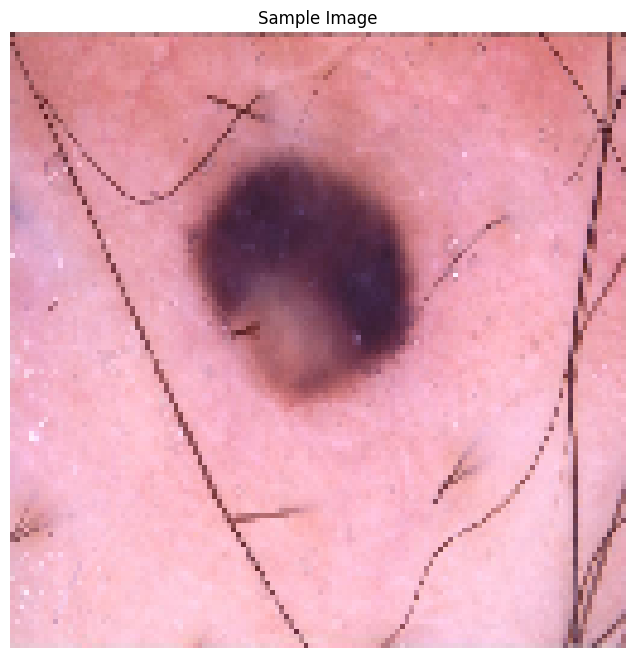

In [ ]:
display_image(sample_images[3])

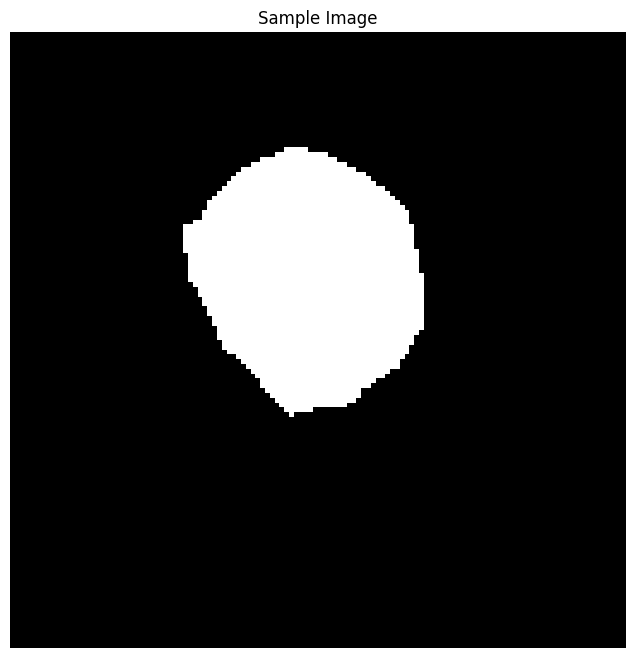

In [ ]:
display_image(sample_masks[3])

In [ ]:
print(sample_masks[1])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
print(sample_images.shape, sample_masks.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16, 128, 128])


In [ ]:
total_samples = len(data_loader.train_dataloader().dataset)
print(total_samples)

900


In [ ]:
total_samples = len(data_loader.test_dataloader().dataset)
print(total_samples)

379


In [ ]:
# def crop_img(tensor, target_tensor):
#   target_size = target_tensor.size()[2]
#   tensor_size = tensor.size()[2]
#   delta = tensor_size - target_size
#   delta = delta // 2
#   return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

In [ ]:
def double_conv(in_c, out_c):
  conv = torch.nn.Sequential(
    torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
    torch.nn.ReLU(inplace=True)
  )
  return conv

In [ ]:
class SegmentationModel(torch.nn.Module):
  def __init__(self, dropout_prob=0.5):
    super(SegmentationModel, self).__init__()
    self.encoder = mobilenet_v2(weights='DEFAULT', progress=True)
    self.encoder_features = list(self.encoder.features.children())
    self.encoder_features = self.encoder_features[:-1]

    for params in self.encoder.parameters():
        params.requires_grad = False

    self.upconv1 = torch.nn.ConvTranspose2d(320, 160, kernel_size=2, stride=2)
    # self.conv1 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.conv1 = double_conv(256, 256)
    self.bn1 = torch.nn.BatchNorm2d(256)
    self.dropout1 = torch.nn.Dropout2d(dropout_prob)

    self.upconv2 = torch.nn.ConvTranspose2d(256, 96, kernel_size=2, stride=2)
    # self.conv2 = torch.nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.conv2 = double_conv(128, 64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.dropout2 = torch.nn.Dropout2d(dropout_prob)

    self.upconv3 = torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
    # self.conv3 = torch.nn.Conv2d(56, 28, kernel_size=3, padding=1)
    self.conv3 = double_conv(56, 28)
    self.bn3 = torch.nn.BatchNorm2d(28)
    self.dropout3 = torch.nn.Dropout2d(dropout_prob)

    self.upconv4 = torch.nn.ConvTranspose2d(28, 16, kernel_size=2, stride=2)
    self.conv4 = torch.nn.Conv2d(32, 8, kernel_size=3, padding=1)
    self.bn4 = torch.nn.BatchNorm2d(32)
    self.dropout4 = torch.nn.Dropout2d(dropout_prob)

    self.upconv5 = torch.nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)

    self._init_weights()

  def _init_weights(self):
      for m in self.modules():
          if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
              torch.nn.init.kaiming_normal_(m.weight)
              if m.bias is not None:
                  torch.nn.init.constant_(m.bias, 0)

  def forward(self, x):
    # print("1.", x.shape)
    outputs = []
    for layer in self.encoder_features:
      x = layer(x)
      # print("mm.", x.shape)
      outputs.append(x)
    # print(len(outputs))

    x = self.upconv1(x)
    # print("3.", x.shape)
    x = torch.cat([x, outputs[-5]], dim=1)
    x = self.conv1(x)
    # print("4.", x.shape)
    # x = torch.nn.functional.relu(self.conv1(x))
    # print("5.", x.shape)
    x = self.bn1(x)
    x = self.dropout1(x)
    # print("6.", x.shape)

    x = self.upconv2(x)
    # print("7.", x.shape)
    x = torch.cat([x, outputs[5]], dim=1)
    # print("8.", x.shape)
    # x = torch.nn.functional.relu(self.conv2(x))
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.dropout2(x)
    # print("9.", x.shape)

    x = self.upconv3(x)
    # print("10.", x.shape)
    x = torch.cat([x, outputs[3]], dim=1)
    # print("11.", x.shape)
    # x = torch.nn.functional.relu(self.conv3(x))
    x = self.conv3(x)
    # print("12.", x.shape)
    x = self.bn3(x)
    x = self.dropout3(x)

    x = self.upconv4(x)
    # print("13.", x.shape)
    x = torch.cat([x, outputs[1]], dim=1)
    # print("14.", x.shape)
    # x = torch.nn.functional.relu(self.conv4(x))
    # # print("14.", x.shape)
    x = self.bn4(x)
    x = self.dropout4(x)

    x = self.upconv5(x)
    # print("15.", x.shape)

    # x = torch.sigmoid(x)
    # threshold = 0.5
    # x = (x > threshold).float()

    return x


In [ ]:
input_image = torch.rand(32, 3, 128, 128)

In [ ]:
model = SegmentationModel()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 66.5MB/s]


In [ ]:
out = model(input_image)
# print(out.shape)
print(out)

tensor([[[[ -2.2986,  -2.9864,  -7.6976,  ...,  -7.3916,  -3.9206,  -1.9682],
          [ -1.8592,  -6.3376,  -3.5488,  ...,   3.3887,  -1.7729,  -5.1740],
          [ -3.5931,  -9.4690,  -8.2350,  ...,  -4.4372,  -5.4255, -11.6405],
          ...,
          [  2.6943, -13.4463,   3.4012,  ...,   2.2953,  -7.9990,  -0.5729],
          [ -7.5092,  -7.4660,  -6.5593,  ...,  -5.0389,  -2.8705, -13.1030],
          [ -0.6340, -13.7772,  -1.0503,  ...,  -2.6852,  -2.8680,  -5.4236]]],


        [[[  1.4264,  -5.6536,   3.0127,  ...,  -3.7569,   4.7554,   0.8770],
          [ -6.6975,  -3.6838,  -4.2614,  ...,   0.4206,  -3.0108,   2.9781],
          [ -2.4202,  -3.6857,  -1.6998,  ...,   1.6186,   6.5373,  -1.3192],
          ...,
          [ -4.6560,   2.2800,   3.1821,  ...,   0.7998,  -2.5687,  -1.7161],
          [  2.7209,  -1.7700, -10.1295,  ...,   0.6541,   2.6075,  -6.9687],
          [-10.1649,  -1.0306,  -4.5957,  ...,  -0.5449,  -6.6375,   1.4221]]],


        [[[ -3.8599,  -2.3

In [ ]:
def dice_coefficient(predicted, target):
  smooth = 1.0
  predicted_flat = predicted.view(-1)
  target_flat = target.view(-1)
  intersection = (predicted_flat * target_flat).sum()
  return (2.0 * intersection + smooth) / (predicted_flat.sum() + target_flat.sum() + smooth)

In [ ]:
class DiceBCELoss(torch.nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(DiceBCELoss, self).__init__()

  def forward(self, inputs, targets, smooth=1):
    # print("d1 ", inputs.shape, targets.shape)
    inputs = torch.sigmoid(inputs)
    # print("d2 ", inputs.shape, targets.shape)

    # threshold = 0.5
    # inputs = torch.where(inputs > threshold, torch.tensor(1.0, requires_grad=True).to(inputs.device), torch.tensor(0.0, requires_grad=True).to(inputs.device))
    # print("d31 ", inputs.shape, targets.shape)
    # inputs = inputs.permute(0, 2, 3, 1).contiguous().view(-1, 2)
    inputs = inputs.contiguous().view(-1)
    # print("d3 ", inputs.shape, targets.shape)
    targets = targets.view(-1)
    # print("d4 ", inputs.shape, targets.shape)

    intersection = (inputs * targets).sum()
    # print("d5 ", inputs.shape, targets.shape)
    dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
    # print("d6 ", inputs.shape, targets.shape)
    BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
    # print("d7 ", inputs.shape, targets.shape)
    Dice_BCE = BCE + dice_loss

    return Dice_BCE


In [ ]:
images = []
predicted_mask = []
label_mask = []

images_2 = []
predicted_mask_2 = []
label_mask_2 = []

def evaluation_dice(model, loss_fn, data_loader, isTest=False, isFineTuned=False):
  model.eval()
  total, dice_sum = 0, 0
  running_loss = 0.0

  with torch.no_grad():
    for data in data_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      threshold = 0.5
      # outputs = torch.where(outputs > threshold, torch.tensor(1.0, requires_grad=True).to(outputs.device), torch.tensor(0.0, requires_grad=True).to(outputs.device))
      outputs = (outputs > threshold).float()

      loss = loss_fn(outputs, labels)
      running_loss += loss.item()

      if isTest:
        images.append(inputs.cpu())
        predicted_mask.append(outputs.cpu())
        label_mask.append(labels.cpu())

      if isTest and isFineTuned:
        images_2.append(inputs.cpu())
        predicted_mask_2.append(outputs.cpu())
        label_mask_2.append(labels.cpu())

      predicted = torch.sigmoid(outputs) > 0.5
      dice = dice_coefficient(predicted.float(), labels.float())
      dice_sum += dice.item() * inputs.size(0)
      total += inputs.size(0)
    data_loss = running_loss / len(data_loader)

  model.train()
  return dice_sum / total, data_loss

In [ ]:
def train_model(model, train_loader, test_loader, criterion, loss_fn, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, targets in tqdm(train_loader, desc='Training'):
    inputs, targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()
    # print("1.", inputs.shape, targets.shape)
    outputs = model(inputs)
    # print("2.", outputs.shape)
    # outputs = outputs.permute(0, 2, 3, 1).contiguous().view(-1, 2)
    # print("3.", outputs.shape)
    # outputs = outputs.view(-1, 1)
    # targets = targets.view(-1).long()
    # print("4.")
    # loss = criterion(outputs, targets)

    loss = loss_fn(outputs, targets)

    # print("5.", loss)
    loss.backward()
    # print("6.")
    optimizer.step()

    running_loss += loss.item()
    # _, predicted = torch.max(outputs, 1)
    # total += targets.size(0)
    # correct += (predicted == targets).sum().item()

  train_loss = running_loss / len(train_loader)
  # train_accuracy = correct / total

  # accuracy_training = evaluation(model, train_loader)
  # accuracy_test = evaluation(model, test_loader)
  accuracy_training_dice, _ = evaluation_dice(model, loss_fn, train_loader)
  accuracy_test_dice, test_loss = evaluation_dice(model, loss_fn, test_loader)

  return train_loss, accuracy_training_dice, accuracy_test_dice, test_loss
  # return train_loss, accuracy_training, accuracy_test

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

model = SegmentationModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = DiceBCELoss()

In [ ]:
training_loss_per_epoch = []
testing_loss_per_epoch = []
training_accuracy_per_epoch = []
testing_accuracy_per_epoch = []
for epoch in range(NUM_EPOCH):
  train_loss, train_accuracy, test_accuracy, test_loss = train_model(model, data_loader.train_dataloader(), data_loader.test_dataloader(), criterion, loss_fn, optimizer, device)
  training_loss_per_epoch.append(train_loss)
  testing_loss_per_epoch.append(test_loss)
  training_accuracy_per_epoch.append(train_accuracy)
  testing_accuracy_per_epoch.append(test_accuracy)
  print(f"Epoch [{epoch+1}/{NUM_EPOCH}]:  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")

Training: 100%|██████████| 57/57 [05:33<00:00,  5.85s/it]


Epoch [1/20]:  Train Loss: 2.1530 | Test Loss: 1.2496 | Train Acc: 0.6213 | Test Acc: 0.6770


Training: 100%|██████████| 57/57 [00:41<00:00,  1.37it/s]


Epoch [2/20]:  Train Loss: 1.5190 | Test Loss: 1.2100 | Train Acc: 0.6791 | Test Acc: 0.7475


Training: 100%|██████████| 57/57 [00:42<00:00,  1.34it/s]


Epoch [3/20]:  Train Loss: 1.2200 | Test Loss: 1.1997 | Train Acc: 0.7194 | Test Acc: 0.7770


Training: 100%|██████████| 57/57 [00:41<00:00,  1.36it/s]


Epoch [4/20]:  Train Loss: 1.1224 | Test Loss: 1.1902 | Train Acc: 0.7234 | Test Acc: 0.7907


Training: 100%|██████████| 57/57 [00:42<00:00,  1.34it/s]


Epoch [5/20]:  Train Loss: 1.0429 | Test Loss: 1.1935 | Train Acc: 0.7290 | Test Acc: 0.7876


Training: 100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Epoch [6/20]:  Train Loss: 0.9709 | Test Loss: 1.1849 | Train Acc: 0.7323 | Test Acc: 0.7985


Training: 100%|██████████| 57/57 [00:41<00:00,  1.36it/s]


Epoch [7/20]:  Train Loss: 0.9407 | Test Loss: 1.1840 | Train Acc: 0.7350 | Test Acc: 0.8000


Training: 100%|██████████| 57/57 [00:41<00:00,  1.36it/s]


Epoch [8/20]:  Train Loss: 0.9240 | Test Loss: 1.1818 | Train Acc: 0.7343 | Test Acc: 0.8052


Training: 100%|██████████| 57/57 [00:43<00:00,  1.31it/s]


Epoch [9/20]:  Train Loss: 0.8551 | Test Loss: 1.1814 | Train Acc: 0.7535 | Test Acc: 0.8114


Training: 100%|██████████| 57/57 [00:42<00:00,  1.34it/s]


Epoch [10/20]:  Train Loss: 0.8415 | Test Loss: 1.1794 | Train Acc: 0.7463 | Test Acc: 0.8143


Training: 100%|██████████| 57/57 [00:42<00:00,  1.33it/s]


Epoch [11/20]:  Train Loss: 0.8288 | Test Loss: 1.1782 | Train Acc: 0.7522 | Test Acc: 0.8162


Training: 100%|██████████| 57/57 [00:43<00:00,  1.31it/s]


Epoch [12/20]:  Train Loss: 0.7884 | Test Loss: 1.1791 | Train Acc: 0.7490 | Test Acc: 0.8203


Training: 100%|██████████| 57/57 [00:45<00:00,  1.25it/s]


Epoch [13/20]:  Train Loss: 0.7704 | Test Loss: 1.1785 | Train Acc: 0.7731 | Test Acc: 0.8206


Training: 100%|██████████| 57/57 [00:50<00:00,  1.13it/s]


Epoch [14/20]:  Train Loss: 0.7442 | Test Loss: 1.1801 | Train Acc: 0.7593 | Test Acc: 0.8171


Training: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


Epoch [15/20]:  Train Loss: 0.7445 | Test Loss: 1.1790 | Train Acc: 0.7443 | Test Acc: 0.8114


Training: 100%|██████████| 57/57 [00:43<00:00,  1.31it/s]


Epoch [16/20]:  Train Loss: 0.7244 | Test Loss: 1.1761 | Train Acc: 0.7635 | Test Acc: 0.8230


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00it/s]


Epoch [17/20]:  Train Loss: 0.7200 | Test Loss: 1.1767 | Train Acc: 0.7622 | Test Acc: 0.8215


Training: 100%|██████████| 57/57 [00:43<00:00,  1.30it/s]


Epoch [18/20]:  Train Loss: 0.7067 | Test Loss: 1.1790 | Train Acc: 0.7508 | Test Acc: 0.8097


Training: 100%|██████████| 57/57 [00:42<00:00,  1.35it/s]


Epoch [19/20]:  Train Loss: 0.7015 | Test Loss: 1.1741 | Train Acc: 0.7784 | Test Acc: 0.8288


Training: 100%|██████████| 57/57 [00:42<00:00,  1.34it/s]


Epoch [20/20]:  Train Loss: 0.7118 | Test Loss: 1.1750 | Train Acc: 0.7700 | Test Acc: 0.8233


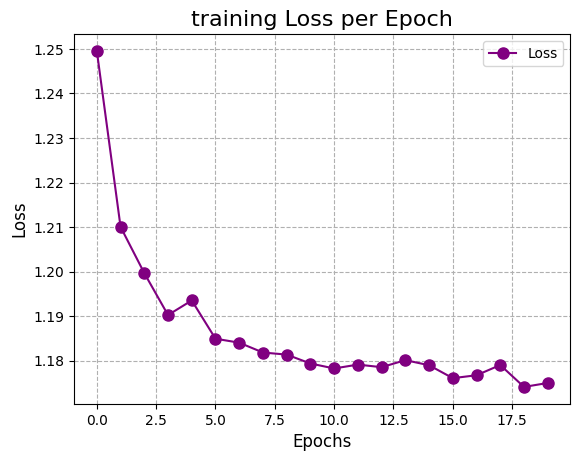

In [ ]:
plt.plot(testing_loss_per_epoch, label="Loss", color="purple", linestyle='-', marker='o', markersize=8)
plt.title("training Loss per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

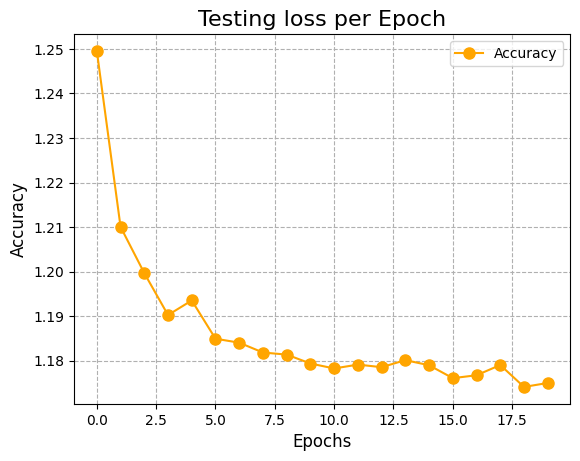

In [ ]:
plt.plot(testing_loss_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Testing loss per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

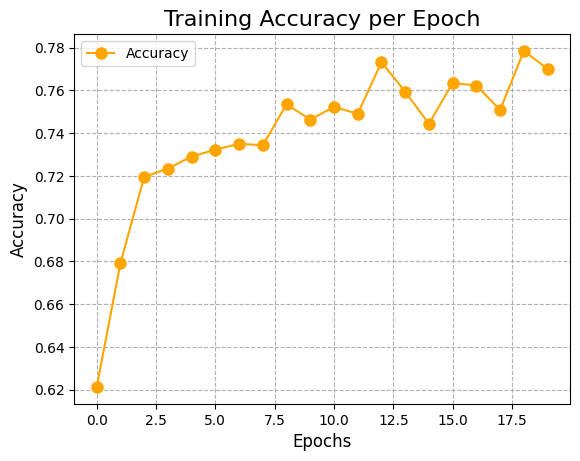

In [ ]:
plt.plot(training_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Training Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

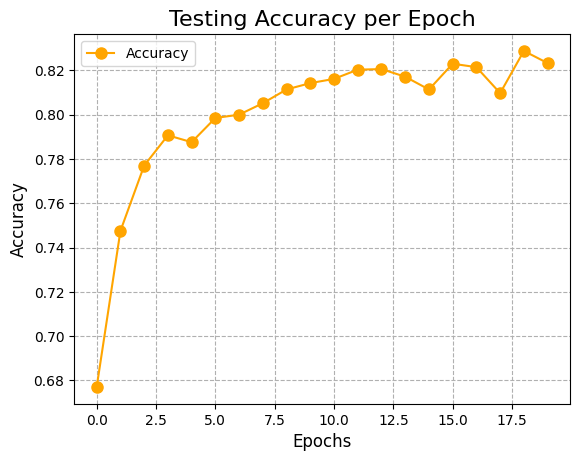

In [ ]:
plt.plot(testing_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Testing Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

In [ ]:
evaluation_dice(model, loss_fn, data_loader.test_dataloader(), isTest=True)

(0.8232882916140997, 1.1749901175498962)

In [ ]:
# def noramalize_img(img):
#   predicted_mask_tensor = torch.tensor(img)

#   min_value = torch.min(predicted_mask_tensor)
#   max_value = torch.max(predicted_mask_tensor)

#   normalized_predicted_mask = (predicted_mask_tensor - min_value) / (max_value - min_value)
#   inverted_predicted_mask = 1 - normalized_predicted_mask

#   # print(normalized_predicted_mask)
#   return inverted_predicted_mask

In [ ]:
print(predicted_mask[2][1])
print(predicted_mask[2][1].shape)
print(label_mask[2][1].shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 128, 128])
torch.Size([128, 128])


In [ ]:
def plot_images(image1, image2, image3):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

  pil_image1 = transforms.functional.to_pil_image(image1)
  pil_image2 = transforms.functional.to_pil_image(image2)

  # grayscale_predicted_mask = torch.mean(image3, dim=0)
  # threshold = 0.5  # Adjust threshold value as needed
  # black_white_predicted_mask = (grayscale_predicted_mask > threshold).float() * 255

  pil_image3 = transforms.functional.to_pil_image(image3)

  axes[0].imshow(pil_image1)
  axes[0].set_title('image')
  axes[0].axis('off')

  axes[1].imshow(pil_image2)
  axes[1].set_title('mask')
  axes[1].axis('off')

  axes[2].imshow(pil_image3)
  axes[2].set_title('predicted mask')
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
for i in range(5):
  # plot_images(images[2][i+1], label_mask[2][i+1], noramalize_img(predicted_mask[2][i+1]))
  plot_images(images[2][i+1], label_mask[2][i+1], predicted_mask[2][i+1])

In [ ]:
def calculate_iou(pred_mask, true_mask):
  intersection = torch.logical_and(pred_mask.bool(), true_mask.bool()).float()
  union = torch.logical_or(pred_mask.bool(), true_mask.bool()).float()
  iou_score = torch.sum(intersection) / torch.sum(union)
  return iou_score.item()

In [ ]:
  iou_scores = []

  for i in range(len(images)):
    for j in range(len(images[i])):
      # grayscale_predicted_mask = torch.mean(noramalize_img(predicted_mask[i][j]), dim=0)
      # threshold = 0.5  # Adjust threshold value as needed
      # black_white_predicted_mask = (grayscale_predicted_mask > threshold).float() * 255
      # iou = calculate_iou(1 - black_white_predicted_mask, label_mask[i][j])
      iou = calculate_iou(predicted_mask[i][j], label_mask[i][j])
      iou_scores.append(iou)

In [ ]:
average_iou = np.mean(iou_scores)
print("Average IoU:", average_iou)

Average IoU: 0.7124457530244831


In [ ]:
def dice_score(predicted_mask, actual_mask):
    predicted_mask_flat = predicted_mask.flatten()
    actual_mask_flat = actual_mask.flatten()

    intersection = torch.sum(predicted_mask_flat * actual_mask_flat)
    dice = (2. * intersection) / (torch.sum(predicted_mask_flat) + torch.sum(actual_mask_flat))
    return dice.item()

def average_dice_score(predicted_masks, actual_masks):
    dice_scores = []
    for predicted_mask, actual_mask in zip(predicted_masks, actual_masks):
        dice_scores.append(dice_score(torch.tensor(predicted_mask), torch.tensor(actual_mask)))  # Convert to PyTorch tensors
    return np.mean(dice_scores)

In [ ]:
average_dice = average_dice_score(predicted_mask, label_mask)
print("Average Dice Score:", average_dice)

Average Dice Score: 0.8407600608964761


<ipython-input-63-7383d73cbd53>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_scores.append(dice_score(torch.tensor(predicted_mask), torch.tensor(actual_mask)))  # Convert to PyTorch tensors


In [ ]:
def count_trainable_and_non_trainable_parameters(model):
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
  total_params = sum(p.numel() for p in model.parameters())
  return trainable_params, non_trainable_params, total_params

In [ ]:
trainable_params, non_trainable_params, total_params = count_trainable_and_non_trainable_parameters(model)
print("Total Parameters: ", total_params)
print("Trainable Parameters: ", trainable_params)
print("Non Trainable Parameters: ", non_trainable_params)

Total Parameters:  5133569
Trainable Parameters:  1628697
Non Trainable Parameters:  3504872


In [ ]:
f1_scores = []

for predicted, label in zip(predicted_mask, label_mask):
  predicted_flat = predicted.flatten()
  label_flat = label.flatten()

  f1 = f1_score(label_flat, predicted_flat)
  f1_scores.append(f1)

average_f1_score = sum(f1_scores) / len(f1_scores)
print("Average F1 Score:", average_f1_score)

Average F1 Score: 0.82334046400804


In [ ]:
class SegmentationModel(torch.nn.Module):
  def __init__(self, dropout_prob=0.5):
    super(SegmentationModel, self).__init__()
    self.encoder = mobilenet_v2(weights='DEFAULT', progress=True)
    self.encoder_features = list(self.encoder.features.children())
    self.encoder_features = self.encoder_features[:-1]

    for params in self.encoder.parameters():
        params.requires_grad = False

    for param in self.encoder.features[-13:].parameters():
      param.requires_grad = True

    self.upconv1 = torch.nn.ConvTranspose2d(320, 160, kernel_size=2, stride=2)
    # self.conv1 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.conv1 = double_conv(256, 256)
    self.bn1 = torch.nn.BatchNorm2d(256)
    self.dropout1 = torch.nn.Dropout2d(dropout_prob)

    self.upconv2 = torch.nn.ConvTranspose2d(256, 96, kernel_size=2, stride=2)
    # self.conv2 = torch.nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.conv2 = double_conv(128, 64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.dropout2 = torch.nn.Dropout2d(dropout_prob)

    self.upconv3 = torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
    # self.conv3 = torch.nn.Conv2d(56, 28, kernel_size=3, padding=1)
    self.conv3 = double_conv(56, 28)
    self.bn3 = torch.nn.BatchNorm2d(28)
    self.dropout3 = torch.nn.Dropout2d(dropout_prob)

    self.upconv4 = torch.nn.ConvTranspose2d(28, 16, kernel_size=2, stride=2)
    self.conv4 = torch.nn.Conv2d(32, 8, kernel_size=3, padding=1)
    self.bn4 = torch.nn.BatchNorm2d(32)
    self.dropout4 = torch.nn.Dropout2d(dropout_prob)

    self.upconv5 = torch.nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)

    self._init_weights()

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
          torch.nn.init.constant_(m.bias, 0)

  def forward(self, x):
    # print("1.", x.shape)
    outputs = []
    for layer in self.encoder_features:
      x = layer(x)
      # print("mm.", x.shape)
      outputs.append(x)
    # print(len(outputs))

    x = self.upconv1(x)
    # print("3.", x.shape)
    x = torch.cat([x, outputs[-5]], dim=1)
    x = self.conv1(x)
    # print("4.", x.shape)
    # x = torch.nn.functional.relu(self.conv1(x))
    # print("5.", x.shape)
    x = self.bn1(x)
    x = self.dropout1(x)
    # print("6.", x.shape)

    x = self.upconv2(x)
    # print("7.", x.shape)
    x = torch.cat([x, outputs[5]], dim=1)
    # print("8.", x.shape)
    # x = torch.nn.functional.relu(self.conv2(x))
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.dropout2(x)
    # print("9.", x.shape)

    x = self.upconv3(x)
    # print("10.", x.shape)
    x = torch.cat([x, outputs[3]], dim=1)
    # print("11.", x.shape)
    # x = torch.nn.functional.relu(self.conv3(x))
    x = self.conv3(x)
    # print("12.", x.shape)
    x = self.bn3(x)
    x = self.dropout3(x)

    x = self.upconv4(x)
    # print("13.", x.shape)
    x = torch.cat([x, outputs[1]], dim=1)
    # print("14.", x.shape)
    # x = torch.nn.functional.relu(self.conv4(x))
    # # print("14.", x.shape)
    x = self.bn4(x)
    x = self.dropout4(x)

    x = self.upconv5(x)
    # print("15.", x.shape)

    # # x = torch.sigmoid(x)
    # # threshold = 0.5
    # # x = (x > threshold).float()

    return x

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

model = SegmentationModel().to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = DiceBCELoss()

In [ ]:
training_loss_per_epoch = []
testing_loss_per_epoch = []
training_accuracy_per_epoch = []
testing_accuracy_per_epoch = []
for epoch in range(NUM_EPOCH):
  train_loss, train_accuracy, test_accuracy, test_loss = train_model(model, data_loader.train_dataloader(), data_loader.test_dataloader(), criterion, loss_fn, optimizer, device)
  training_loss_per_epoch.append(train_loss)
  testing_loss_per_epoch.append(test_loss)
  training_accuracy_per_epoch.append(train_accuracy)
  testing_accuracy_per_epoch.append(test_accuracy)
  print(f"Epoch [{epoch+1}/{NUM_EPOCH}]:  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")

Training: 100%|██████████| 57/57 [00:49<00:00,  1.14it/s]


Epoch [1/20]:  Train Loss: 2.3404 | Test Loss: 1.2506 | Train Acc: 0.6198 | Test Acc: 0.6886


Training: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


Epoch [2/20]:  Train Loss: 1.6311 | Test Loss: 1.2347 | Train Acc: 0.6790 | Test Acc: 0.7372


Training: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


Epoch [3/20]:  Train Loss: 1.3062 | Test Loss: 1.1870 | Train Acc: 0.7293 | Test Acc: 0.8048


Training: 100%|██████████| 57/57 [00:43<00:00,  1.31it/s]


Epoch [4/20]:  Train Loss: 1.1379 | Test Loss: 1.1797 | Train Acc: 0.7548 | Test Acc: 0.8191


Training: 100%|██████████| 57/57 [00:43<00:00,  1.30it/s]


Epoch [5/20]:  Train Loss: 1.0239 | Test Loss: 1.1753 | Train Acc: 0.7472 | Test Acc: 0.8227


Training: 100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Epoch [6/20]:  Train Loss: 0.9574 | Test Loss: 1.1765 | Train Acc: 0.7427 | Test Acc: 0.8259


Training: 100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Epoch [7/20]:  Train Loss: 0.9278 | Test Loss: 1.1817 | Train Acc: 0.7343 | Test Acc: 0.8040


Training: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


Epoch [8/20]:  Train Loss: 0.8777 | Test Loss: 1.1755 | Train Acc: 0.7715 | Test Acc: 0.8265


Training: 100%|██████████| 57/57 [00:42<00:00,  1.33it/s]


Epoch [9/20]:  Train Loss: 0.8377 | Test Loss: 1.1713 | Train Acc: 0.7813 | Test Acc: 0.8372


Training: 100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Epoch [10/20]:  Train Loss: 0.8039 | Test Loss: 1.1697 | Train Acc: 0.7773 | Test Acc: 0.8427


Training: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


Epoch [11/20]:  Train Loss: 0.7912 | Test Loss: 1.1707 | Train Acc: 0.7624 | Test Acc: 0.8331


Training: 100%|██████████| 57/57 [00:43<00:00,  1.33it/s]


Epoch [12/20]:  Train Loss: 0.7464 | Test Loss: 1.1661 | Train Acc: 0.7952 | Test Acc: 0.8485


Training: 100%|██████████| 57/57 [00:44<00:00,  1.30it/s]


Epoch [13/20]:  Train Loss: 0.7306 | Test Loss: 1.1652 | Train Acc: 0.7905 | Test Acc: 0.8498


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04it/s]


Epoch [14/20]:  Train Loss: 0.7134 | Test Loss: 1.1664 | Train Acc: 0.7925 | Test Acc: 0.8485


Training: 100%|██████████| 57/57 [01:00<00:00,  1.05s/it]


Epoch [15/20]:  Train Loss: 0.6947 | Test Loss: 1.1621 | Train Acc: 0.7996 | Test Acc: 0.8577


Training: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


Epoch [16/20]:  Train Loss: 0.6645 | Test Loss: 1.1636 | Train Acc: 0.7961 | Test Acc: 0.8571


Training: 100%|██████████| 57/57 [00:43<00:00,  1.30it/s]


Epoch [17/20]:  Train Loss: 0.6609 | Test Loss: 1.1632 | Train Acc: 0.7963 | Test Acc: 0.8551


Training: 100%|██████████| 57/57 [00:43<00:00,  1.30it/s]


Epoch [18/20]:  Train Loss: 0.6866 | Test Loss: 1.1618 | Train Acc: 0.8179 | Test Acc: 0.8639


Training: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


Epoch [19/20]:  Train Loss: 0.6411 | Test Loss: 1.1623 | Train Acc: 0.8127 | Test Acc: 0.8602


Training: 100%|██████████| 57/57 [00:44<00:00,  1.28it/s]


Epoch [20/20]:  Train Loss: 0.5905 | Test Loss: 1.1614 | Train Acc: 0.8011 | Test Acc: 0.8583


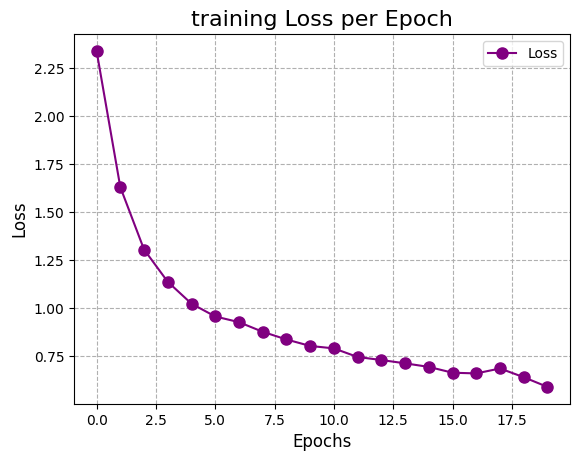

In [ ]:
plt.plot(training_loss_per_epoch, label="Loss", color="purple", linestyle='-', marker='o', markersize=8)
plt.title("training Loss per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

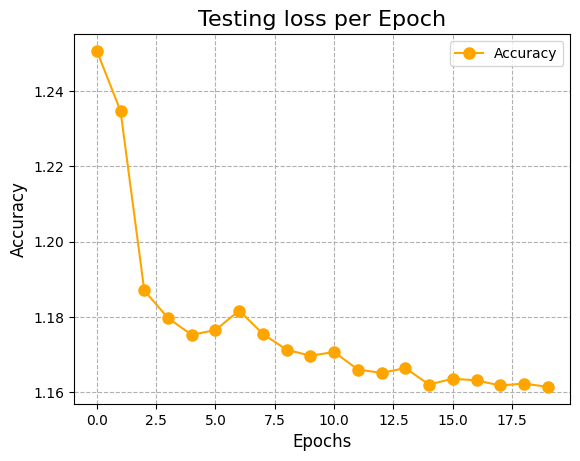

In [ ]:
plt.plot(testing_loss_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Testing loss per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

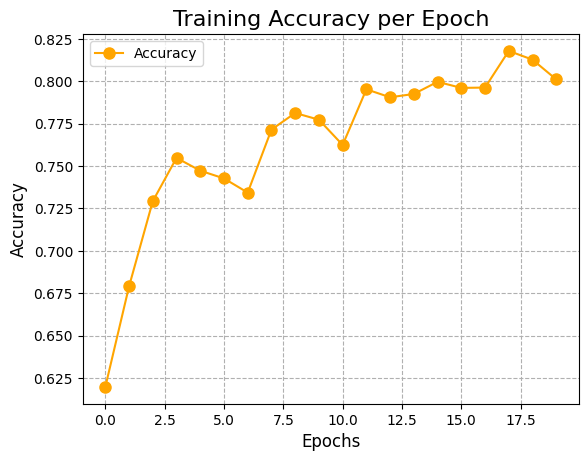

In [ ]:
plt.plot(training_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Training Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

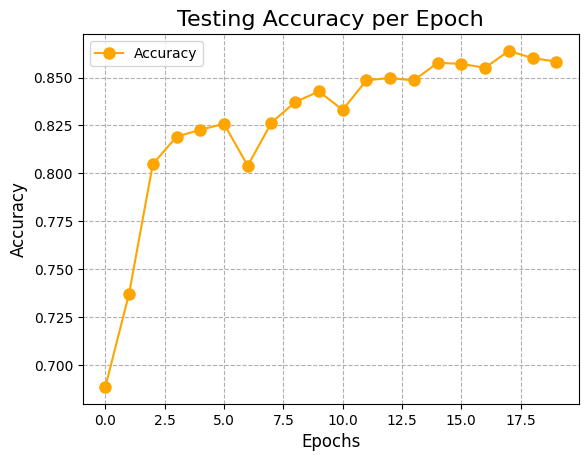

In [ ]:
plt.plot(testing_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Testing Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

In [ ]:
evaluation_dice(model, loss_fn, data_loader.test_dataloader(), isTest=True, isFineTuned=True)

(0.8583267463228633, 1.1614460547765095)

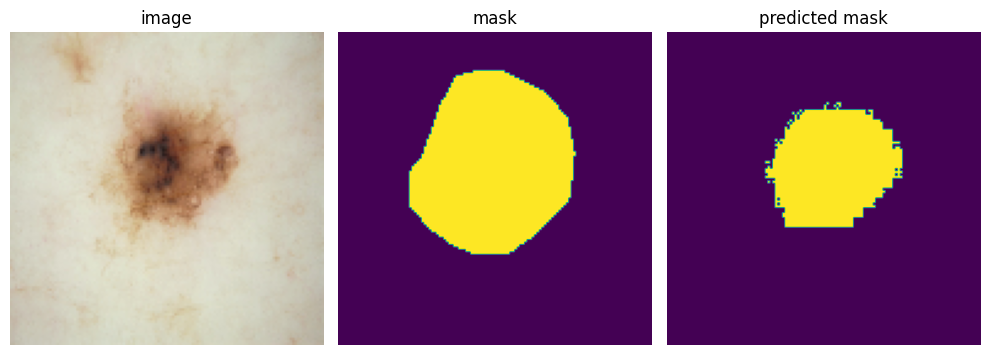

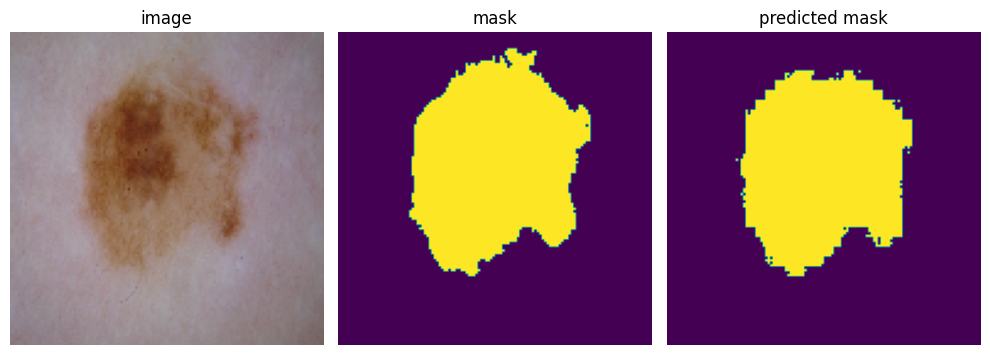

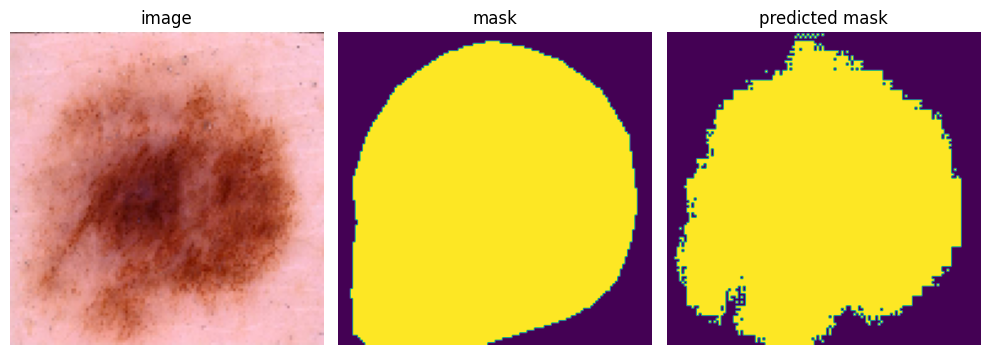

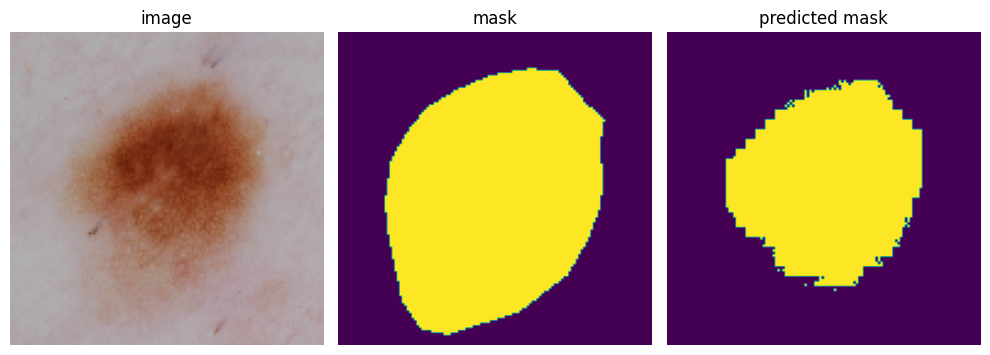

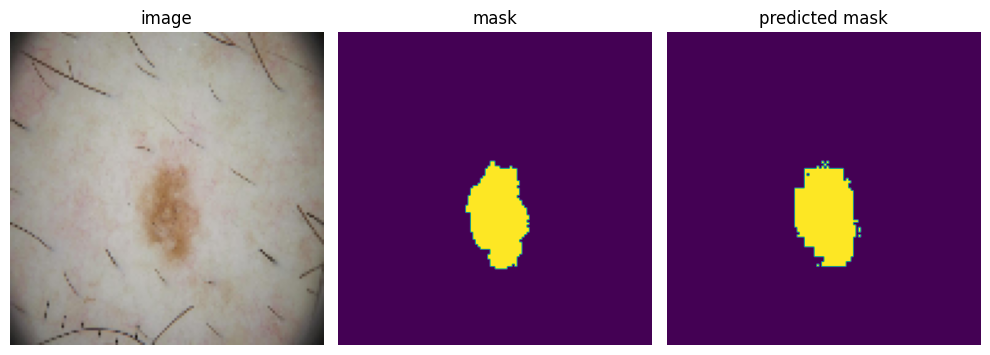

In [ ]:
for i in range(5):
  plot_images(images_2[2][i+1], label_mask_2[2][i+1], predicted_mask_2[2][i+1])

In [ ]:
iou_scores = []

for i in range(len(images_2)):
  for j in range(len(images_2[i])):
    # grayscale_predicted_mask = torch.mean(noramalize_img(predicted_mask[i][j]), dim=0)
    # threshold = 0.5  # Adjust threshold value as needed
    # black_white_predicted_mask = (grayscale_predicted_mask > threshold).float() * 255
    # iou = calculate_iou(1 - black_white_predicted_mask, label_mask[i][j])
    iou = calculate_iou(predicted_mask_2[i][j], label_mask_2[i][j])
    iou_scores.append(iou)

average_iou = np.mean(iou_scores)
print("Average IoU:", average_iou)

Average IoU: 0.7404191171784829


In [ ]:
def dice_score(predicted_mask, actual_mask):
  predicted_mask_flat = predicted_mask.flatten()
  actual_mask_flat = actual_mask.flatten()

  intersection = torch.sum(predicted_mask_flat * actual_mask_flat)
  dice = (2. * intersection) / (torch.sum(predicted_mask_flat) + torch.sum(actual_mask_flat))
  return dice.item()

def average_dice_score(predicted_masks, actual_masks):
  dice_scores = []
  for predicted_mask, actual_mask in zip(predicted_masks, actual_masks):
      dice_scores.append(dice_score(torch.tensor(predicted_mask), torch.tensor(actual_mask)))
  return np.mean(dice_scores)

In [ ]:
average_dice = average_dice_score(predicted_mask_2, label_mask_2)
print("Average Dice Score:", average_dice)

Average Dice Score: 0.8581796561678251


<ipython-input-58-f000aac018ba>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_scores.append(dice_score(torch.tensor(predicted_mask), torch.tensor(actual_mask)))


In [ ]:
trainable_params, non_trainable_params, total_params = count_trainable_and_non_trainable_parameters(model)
print("Total Parameters: ", total_params)
print("Trainable Parameters: ", trainable_params)
print("Non Trainable Parameters: ", non_trainable_params)

Total Parameters:  5133569
Trainable Parameters:  3811929
Non Trainable Parameters:  1321640


In [ ]:
f1_scores = []

for predicted, label in zip(predicted_mask_2, label_mask_2):
  predicted_flat = predicted.flatten()
  label_flat = label.flatten()

  f1 = f1_score(label_flat, predicted_flat)
  f1_scores.append(f1)

average_f1_score = sum(f1_scores) / len(f1_scores)
print("Average F1 Score:", average_f1_score)

Average F1 Score: 0.858179652997708


In [ ]:
!pip install optuna
import optuna

In [ ]:
def hyperparameters(trial):
  learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
  # batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
  weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
  dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)
  # momentum = trial.suggest_float('momentum', 0.0, 0.9)
  step_size = trial.suggest_int('step_size', 1, 10)
  gamma = trial.suggest_float('gamma', 0.1, 0.9)
  beta1 = trial.suggest_float('beta1', 0.1, 0.9)


  # loss_function = torch.nn.CrossEntropyLoss()
  loss_fn = DiceBCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999), weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  loss_epoch_arr = []
  accuracy_per_epoch = []
  for epoch in range(10):
    for i, data in enumerate(data_loader.train_dataloader()):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      # l2_regularization = 0.0
      # for param in neural_network.parameters():
      #   l2_regularization += torch.norm(param, 2)
      # loss += 1e-5 * l2_regularization
      loss.backward()
      # torch.nn.utils.clip_grad_norm_(neural_network.parameters(), max_norm=1)
      optimizer.step()
    # loss_epoch_arr.append(loss.item())
    scheduler.step()
    # accuracy = evaluation(training_data_loader)
    # accuracy_per_epoch.append(accuracy / 100)
    accuracy_training_dice, train_loss = evaluation_dice(model, loss_fn, data_loader.train_dataloader())
    accuracy_test_dice, test_loss = evaluation_dice(model, loss_fn, data_loader.test_dataloader())
    loss_epoch_arr.append(train_loss)
    accuracy_per_epoch.append(accuracy_training_dice)
    # print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {evaluation(test_data_loader)}, Trainig_Accuracy: {evaluation(training_data_loader)}")
    # print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {evaluation(test_data_loader)}, Trainig_Accuracy: {accuracy}")
    print(f"Epoch [{epoch+1}/{10}]:  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {accuracy_training_dice:.4f} | Test Acc: {accuracy_test_dice:.4f}")

  accuracy, _ = evaluation_dice(model, loss_fn, data_loader.test_dataloader())
  return loss_epoch_arr[-1]

study = optuna.create_study(direction='minimize')
study.optimize(hyperparameters, n_trials=15)
best_params = study.best_params
best_learning_rate = best_params['learning_rate']
# best_batch_size = best_params['batch_size']
best_weight_decay = best_params['weight_decay']
best_dropout_prob = best_params['dropout_prob']
# best_momentum = best_params['momentum']
best_step_size = best_params['step_size']
best_gamma = best_params['gamma']
best_beta1 = best_params['beta1']

print("Best Hyperparameters:")
print("Learning Rate:", best_learning_rate)
# print("Batch Size:", best_batch_size)
print("Weight Decay:", best_weight_decay)
print("Dropout Probability:", best_dropout_prob)
# print("Momentum:", best_momentum)
print("Step Size for LR Scheduler:", best_step_size)
print("Gamma for LR Scheduler:", best_gamma)
print("Beta1 (Momentum in Adam):", best_beta1)